In [1]:
# connect to google drive
import os
from google.colab import drive
ROOT_PATH = os.path.join(os.sep, 'content' , 'gdrive')
drive.mount(ROOT_PATH, force_remount = True)

Mounted at /content/gdrive


In [2]:
%cd /content/gdrive/MyDrive/ProgettoAI/ProgettoAI/XAI

/content/gdrive/MyDrive/ProgettoAI/ProgettoAI/XAI


### Importing Libraries

In [3]:
import os
import numpy as np
import pandas as pd
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import random
from PIL import Image
import warnings
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from skimage import filters
from skimage.color import rgb2gray
from tensorflow.keras.optimizers import Adam

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

warnings.filterwarnings('ignore')

2.9.2


### Seed

In [4]:
seed = 1926
tf.random.set_seed(seed)
np.random.seed(seed)
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
tf.compat.v1.set_random_seed(seed)

### Load Image Dataset

In [5]:
data_dir = '/content/gdrive/MyDrive/ProgettoAI/ProgettoAI/Processed_dataset'
# training_dir = os.path.join(data_dir, 'train')
validation_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

In [6]:
# Input Parameters
img_w = 256
img_h = 256
classes = 3

In [7]:
# Create an ImageDataGenerator object
datagen = ImageDataGenerator()

# training_set = datagen.flow_from_directory(
#         directory = training_dir,
#         class_mode = 'categorical',
#         color_mode = 'rgb',
#         classes = None,
#         seed = seed,
#         target_size = (img_h, img_w),
#         batch_size = batch_size,
#         shuffle = True
#     )

validation_set = datagen.flow_from_directory(
        directory = validation_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = 2327,
        shuffle = False
    )

test_set = datagen.flow_from_directory(
        directory = test_dir,
        class_mode = 'categorical',
        color_mode = 'rgb',
        classes = None,
        seed = seed,
        target_size = (img_h, img_w),
        batch_size = 2309,
        shuffle = False
    )

Found 2327 images belonging to 3 classes.
Found 2309 images belonging to 3 classes.


### Load Model

In [8]:
import keras.backend as K
def f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [9]:
model = tfk.models.load_model('b2_all_layer', custom_objects = {'f1':f1})
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                              

In [10]:
model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(10**-5), 
                          metrics=['accuracy',
                          tf.keras.metrics.Recall(name='recall'),
                          tf.keras.metrics.Precision(name='precision'),
                          f1])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 256, 256, 3)  0           ['input_5[0][0]']                
                                                                                                  
 normalization_1 (Normalization  (None, 256, 256, 3)  7          ['rescaling_1[0][0]']            
 )                                                                                                
                                                                                              

### Grad-CAM

In [11]:
def GradCam(model, img_array, layer_name, eps=1e-8):
    '''
    Creates a grad-cam heatmap given a model and a layer name contained with that model
    

    Args:
      model: tf model
      img_array: (img_width x img_width) numpy array
      layer_name: str


    Returns 
      uint8 numpy array with shape (img_height, img_width)

    '''

    gradModel = tfk.Model(
			inputs=[model.inputs],
			outputs=[model.get_layer(layer_name).output,
				model.output])
    
    with tf.GradientTape() as tape:
			# cast the image tensor to a float-32 data type, pass the
			# image through the gradient model, and grab the loss
			# associated with the specific class index
      
      # Convert the array image into tensor:
      img_tensor = tf.expand_dims(img_array, axis = -1)
      img_tensor = tf.expand_dims(img_tensor, axis = 0)

      inputs = img_tensor #we use the preprocessed image
      (convOutputs, predictions) = gradModel(inputs)
      loss = predictions[:, int(tf.math.argmax(predictions, axis = 1))]

		# use automatic differentiation to compute the gradients
    grads = tape.gradient(loss, convOutputs)
    
    # compute the guided gradients
    castConvOutputs = tf.cast(convOutputs > 0, "float32")
    castGrads = tf.cast(grads > 0, "float32")
    guidedGrads = castConvOutputs * castGrads * grads
		# the convolution and guided gradients have a batch dimension
		# (which we don't need) so let's grab the volume itself and
		# discard the batch
    convOutputs = convOutputs[0]
    guidedGrads = guidedGrads[0]
    # compute the average of the gradient values, and using them
		# as weights, compute the ponderation of the filters with
		# respect to the weights
    weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
    cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)
  
    # grab the spatial dimensions of the input image and resize
		# the output class activation map to match the input image
		# dimensions
    heatmap = cv2.resize(cam.numpy(), (img_h, img_w))

    # (w, h) = (img_array.shape[2], img_array.shape[1])
    # heatmap = cv2.resize(cam.numpy(), (w, h))
		# # normalize the heatmap such that all values lie in the range
		# # [0, 1], scale the resulting values to the range [0, 255],
		# # and then convert to an unsigned 8-bit integer
    numer = heatmap - np.min(heatmap)
    denom = (heatmap.max() - heatmap.min()) + eps
    heatmap = numer / denom
    # heatmap = (heatmap * 255).astype("uint8")
		# # return the resulting heatmap to the calling function

    return heatmap, predictions


In [14]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

def displayGradCAM(img_array, gradcam, target_label, prediction):
  prediction = np.argmax(prediction)
  prediction = ['N' if prediction == 0  else('P' if prediction == 1 else 'T' )]
  img = img_array/255 # normalization
  target_label = str(target_label)
  prediction = str(prediction)

  fig, axis = plt.subplots(1, 2, figsize=(10,10))
  axis.flat

  # Original Image
  axis[0].imshow(img)
  axis[0].set_title("Inuput image - " + target_label)
  axis[0].axis('off')

  # Grad-CAM
  axis[1].imshow(img)
  im=axis[1].imshow(gradcam, cmap='jet', alpha=0.5)
  title = str(["GradCAM for predicted class: " + prediction[2:-2]])
  axis[1].set_title(title[2:-2])
  axis[1].axis('off')
  cax = make_axes_locatable(axis[1]).append_axes("right", size="5%", pad=0.05) 
  fig.colorbar(im, cax=cax)

In [12]:
# Load a batch of images
images, labels = test_set.next()

--------------------
1230
--------------------
1588
--------------------
1130
--------------------
1648
--------------------
736
--------------------
65
--------------------
91
--------------------
1684
--------------------
205


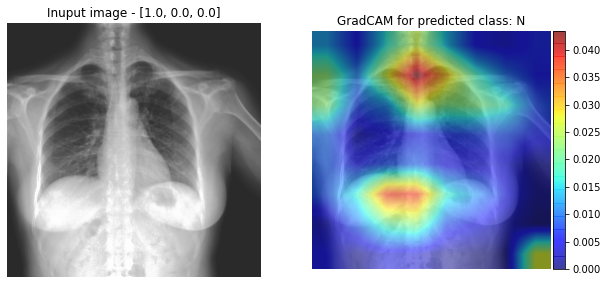

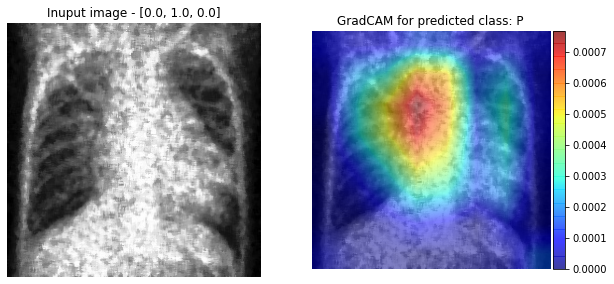

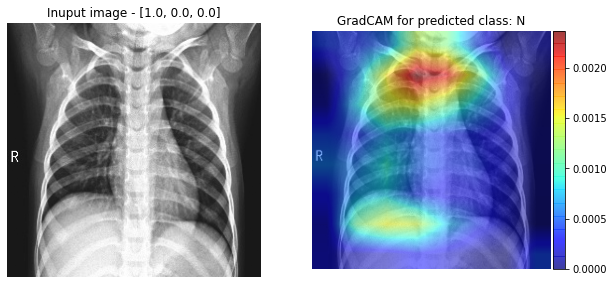

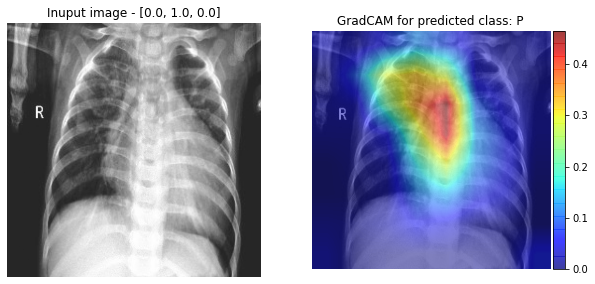

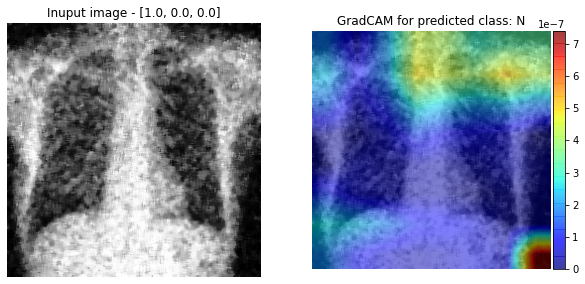

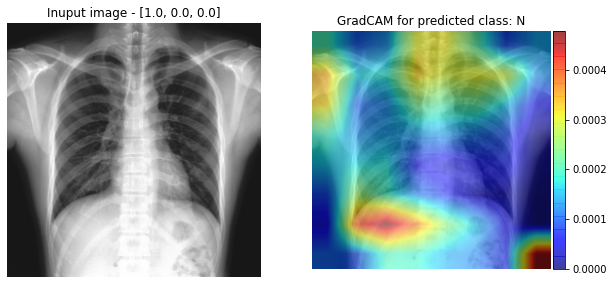

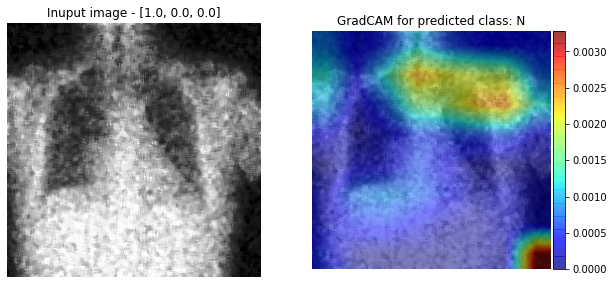

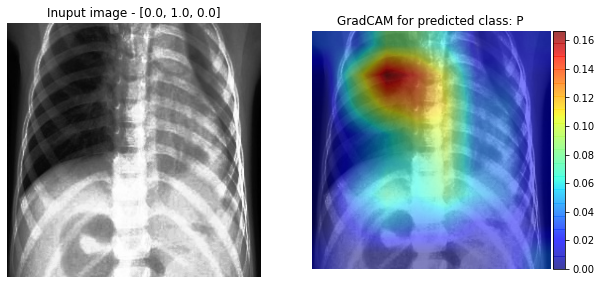

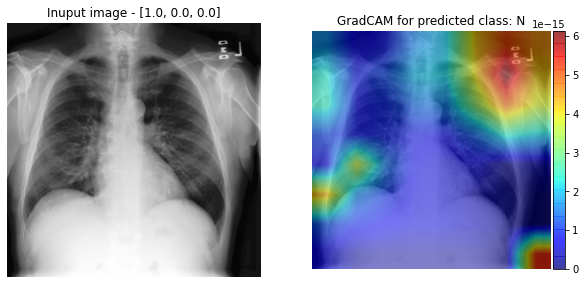

In [15]:
for i in range(9):
  idx = random.randint(0, 2309)
  layer_name = 'top_activation'
  grad_cam, predictions = GradCam(model, images[idx], layer_name)
  displayGradCAM(images[idx], grad_cam, list(labels[idx]), predictions)
  print('--------------------')
  print(idx)

### Model Metrics

In [ ]:
model_predictions = model.predict(test_set)

73/73 [==============================] - 310s 4s/step


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix

labels = ['N', 'P', 'T']

def print_evaluation(y_true, predictions):
    cm = confusion_matrix(y_true, predictions, normalize='pred')
    cm_display = ConfusionMatrixDisplay(cm, display_labels = ['N', 'P', 'T'])
    cm_display.plot()
    
    print(classification_report(y_true, predictions, digits = 4,  target_names = labels))

In [ ]:
y_test = test_set.labels

              precision    recall  f1-score   support

           N     0.9695    0.9806    0.9750      1392
           P     0.9734    0.9811    0.9772       634
           T     0.9580    0.8869    0.9211       283

    accuracy                         0.9693      2309
   macro avg     0.9670    0.9495    0.9578      2309
weighted avg     0.9691    0.9693    0.9690      2309



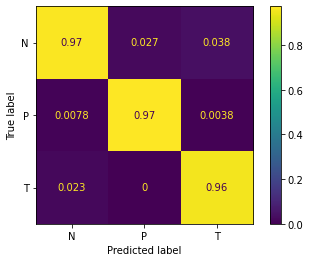

In [ ]:
# Test
print_evaluation(y_test, np.argmax(model_predictions, axis=-1))